### **Load Libraries**

In [1]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from google.colab import drive
import os, shutil
import random
import numpy as np
import pandas as pd
import cv2
import skimage
import matplotlib.pyplot as plt
import skimage.segmentation
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
import tensorflow_hub as hub
import time
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, ConfusionMatrixDisplay  # Added missing imports

# Data augmentation and model preparation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

#### **Define Paths and Load Data**

In [2]:
# Define paths and load data
BASE_PATH = "/content/drive/MyDrive/chest_xray"
TRAIN_PATH = os.path.join(BASE_PATH, "train")
TEST_PATH = os.path.join(BASE_PATH, "test")
MODEL_SAVE_PATH = "/content/drive/MyDrive/chest_xray/New_Models/mobileNetV2_best.h5"

labels = ['NORMAL', 'PNEUMONIA']
img_size = 224

def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                data.append([img_path, label])
            except Exception as e:
                print(e)
    return pd.DataFrame(data, columns=['filepath', 'label'])

# Load data
train_df = get_data(TRAIN_PATH)
test_df = get_data(TEST_PATH)

print(train_df.head())
print(f"\nTrain data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")


                                            filepath   label
0  /content/drive/MyDrive/chest_xray/train/NORMAL...  NORMAL
1  /content/drive/MyDrive/chest_xray/train/NORMAL...  NORMAL
2  /content/drive/MyDrive/chest_xray/train/NORMAL...  NORMAL
3  /content/drive/MyDrive/chest_xray/train/NORMAL...  NORMAL
4  /content/drive/MyDrive/chest_xray/train/NORMAL...  NORMAL

Train data shape: (5233, 2)
Test data shape: (625, 2)


#### **Dataset Distribution**

/tmp/ipython-input-325433677.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


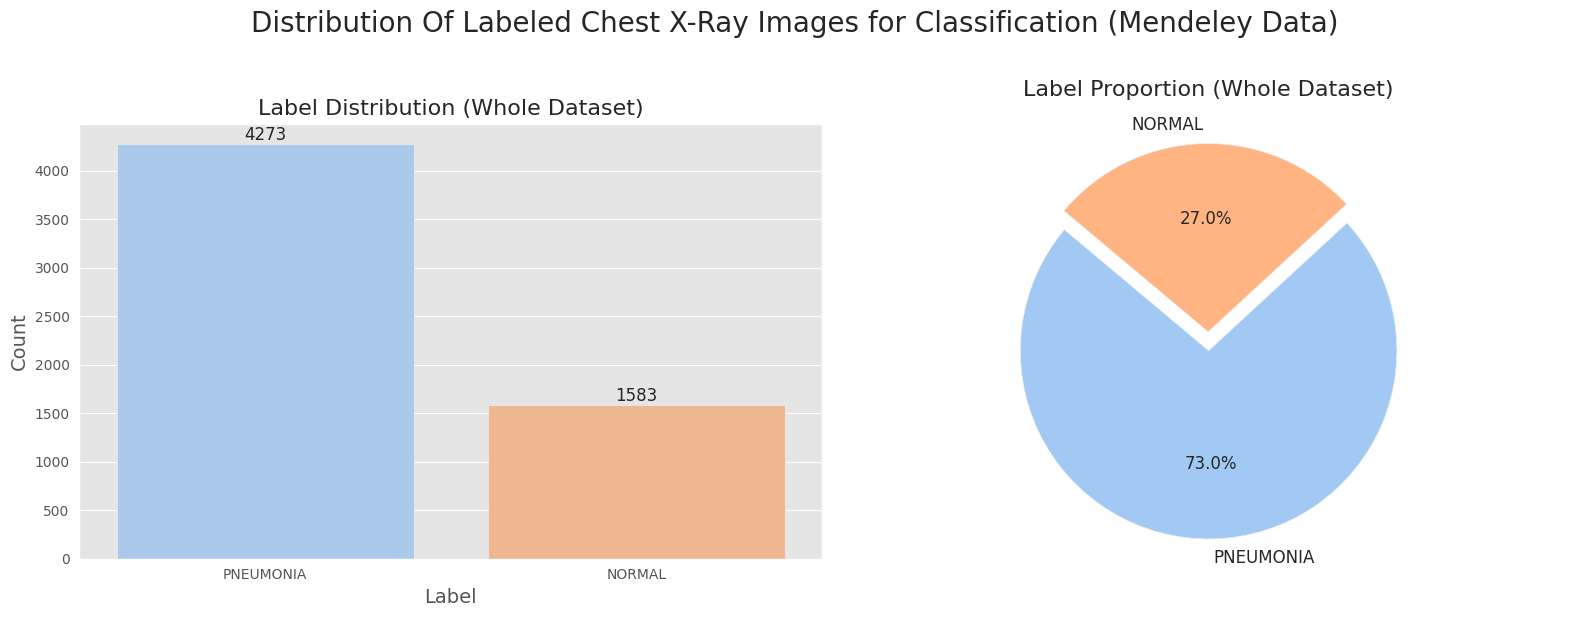

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Combine train and test into a single DataFrame
combined = pd.concat([train_df, test_df], ignore_index=True)

# Remove any entries whose filepath does not end with '.jpeg'
combined = combined[combined['filepath'].str.lower().str.endswith('.jpeg')]

# Count distribution of labels
count_distribution = combined['label'].value_counts()

# Set ggplot-style with seaborn
sns.set_style("whitegrid")
plt.style.use('ggplot')

# Create figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Main title (bold and underlined)
fig.suptitle("Distribution Of Labeled Chest X-Ray Images for Classification (Mendeley Data)", fontsize=20, ha='center', y=1.02)

# Bar chart with counts on axs[0]
colors = sns.color_palette("pastel", len(count_distribution))
ax = sns.barplot(
    x=count_distribution.index,
    y=count_distribution.values,
    palette=colors,
    ax=axs[0]
)
# Annotate bars with counts
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f'{int(height)}',
        (p.get_x() + p.get_width() / 2, height),
        ha='center',
        va='bottom',
        fontsize=12
    )
ax.set_title('Label Distribution (Whole Dataset)', fontsize=16)
ax.set_xlabel('Label', fontsize=14)
ax.set_ylabel('Count', fontsize=14)

# Pie chart with percentages on axs[1]
explode = [0.05] * len(count_distribution)  # Slightly explode all slices for emphasis
wedges, texts, autotexts = axs[1].pie(
    count_distribution.values,
    labels=count_distribution.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    explode=explode,
    textprops={'fontsize': 12}
)
axs[1].set_title('Label Proportion (Whole Dataset)', fontsize=16, pad=20)
axs[1].axis('equal')  # Ensure pie is a circle

# Shift "Normal" label to the left and draw a dashed arrow from its slice
label_list = list(count_distribution.index)
if 'Normal' in label_list:
    idx_norm = label_list.index('Normal')
elif 'normal' in label_list:
    idx_norm = label_list.index('normal')
else:
    idx_norm = None

if idx_norm is not None:
    # Compute wedge centroid
    wedge = wedges[idx_norm]
    mid_angle = (wedge.theta2 + wedge.theta1) / 2
    angle_rad = np.deg2rad(mid_angle)
    x_wedge, y_wedge = np.cos(angle_rad) * 0.7, np.sin(angle_rad) * 0.7

    # Original label position
    x_label, y_label = texts[idx_norm].get_position()
    # Shift label left
    x_new = x_label - 0.15
    y_new = y_label
    texts[idx_norm].set_position((x_new, y_new))

    # Draw dashed arrow from wedge to new label position
    axs[1].annotate(
        "",
        xy=(x_wedge, y_wedge),
        xytext=(x_new, y_new),
        arrowprops={
            'arrowstyle': '->',
            'linestyle': '--',
            'color': 'black',
            'linewidth': 1
        }
    )

plt.tight_layout()
plt.show()

#### **Preprocess Dataset**

In [ ]:
# Create datasets
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 123

# Create data generators
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.1)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.1)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    seed=SEED)

val_generator = val_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    seed=SEED)

test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False)

Found 4710 images belonging to 2 classes.
Found 522 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
# Calculate class weights
def count_files(path):
    normal = len([f for f in os.listdir(os.path.join(path, "NORMAL")) if f.endswith('.jpeg')])
    pneumonia = len([f for f in os.listdir(os.path.join(path, "PNEUMONIA")) if f.endswith('.jpeg')])
    return normal, pneumonia

normal_train, pneumonia_train = count_files(TRAIN_PATH)
class_totals = [normal_train, pneumonia_train]
class_weight = {0: max(class_totals)/class_totals[0],
                1: max(class_totals)/class_totals[1]}

#### **Build model**

In [ ]:
# Build model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,586,177 (9.87 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

#### **Train model**


In [ ]:
# Train model
EPOCHS = 20

checkpoint = ModelCheckpoint(
    filepath=MODEL_SAVE_PATH,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

start_time = time.time()
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[checkpoint],
    class_weight=class_weight
)
end_time = time.time()
print(f"Total training time: {(end_time - start_time)/60:.2f} minutes")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7522 - loss: 0.7291
Epoch 1: val_loss improved from inf to 0.18401, saving model to /content/drive/MyDrive/chest_xray/New_Models/mobileNetV2_best.h5


147/147 ━━━━━━━━━━━━━━━━━━━━ 754s 5s/step - accuracy: 0.7528 - loss: 0.7276 - val_accuracy: 0.9355 - val_loss: 0.1840
Epoch 2/20
  1/147 ━━━━━━━━━━━━━━━━━━━━ 2:34 1s/step - accuracy: 0.9688 - loss: 0.2133

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss did not improve from 0.18401
147/147 ━━━━━━━━━━━━━━━━━━━━ 27s 175ms/step - accuracy: 0.9688 - loss: 0.2133 - val_accuracy: 0.9277 - val_loss: 0.1865
Epoch 3/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9227 - loss: 0.2575
Epoch 3: val_loss improved from 0.18401 to 0.15459, saving model to /content/drive/MyDrive/chest_xray/New_Models/mobileNetV2_best.h5


147/147 ━━━━━━━━━━━━━━━━━━━━ 382s 2s/step - accuracy: 0.9227 - loss: 0.2575 - val_accuracy: 0.9395 - val_loss: 0.1546
Epoch 4/20
  1/147 ━━━━━━━━━━━━━━━━━━━━ 4:36 2s/step - accuracy: 0.9688 - loss: 0.2632
Epoch 4: val_loss did not improve from 0.15459
147/147 ━━━━━━━━━━━━━━━━━━━━ 39s 255ms/step - accuracy: 0.9688 - loss: 0.2632 - val_accuracy: 0.9375 - val_loss: 0.1592
Epoch 5/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9241 - loss: 0.2477
Epoch 5: val_loss improved from 0.15459 to 0.14741, saving model to /content/drive/MyDrive/chest_xray/New_Models/mobileNetV2_best.h5


147/147 ━━━━━━━━━━━━━━━━━━━━ 397s 2s/step - accuracy: 0.9241 - loss: 0.2476 - val_accuracy: 0.9453 - val_loss: 0.1474
Epoch 6/20
  1/147 ━━━━━━━━━━━━━━━━━━━━ 2:53 1s/step - accuracy: 0.8750 - loss: 0.4394
Epoch 6: val_loss improved from 0.14741 to 0.13722, saving model to /content/drive/MyDrive/chest_xray/New_Models/mobileNetV2_best.h5


147/147 ━━━━━━━━━━━━━━━━━━━━ 31s 203ms/step - accuracy: 0.8750 - loss: 0.4394 - val_accuracy: 0.9473 - val_loss: 0.1372
Epoch 7/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9393 - loss: 0.2175
Epoch 7: val_loss improved from 0.13722 to 0.12468, saving model to /content/drive/MyDrive/chest_xray/New_Models/mobileNetV2_best.h5


147/147 ━━━━━━━━━━━━━━━━━━━━ 318s 2s/step - accuracy: 0.9392 - loss: 0.2175 - val_accuracy: 0.9473 - val_loss: 0.1247
Epoch 8/20
  1/147 ━━━━━━━━━━━━━━━━━━━━ 3:23 1s/step - accuracy: 1.0000 - loss: 0.0565
Epoch 8: val_loss did not improve from 0.12468
147/147 ━━━━━━━━━━━━━━━━━━━━ 40s 265ms/step - accuracy: 1.0000 - loss: 0.0565 - val_accuracy: 0.9434 - val_loss: 0.1315
Epoch 9/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9432 - loss: 0.2022
Epoch 9: val_loss improved from 0.12468 to 0.11397, saving model to /content/drive/MyDrive/chest_xray/New_Models/mobileNetV2_best.h5


147/147 ━━━━━━━━━━━━━━━━━━━━ 324s 2s/step - accuracy: 0.9432 - loss: 0.2022 - val_accuracy: 0.9512 - val_loss: 0.1140
Epoch 10/20
  1/147 ━━━━━━━━━━━━━━━━━━━━ 2:41 1s/step - accuracy: 1.0000 - loss: 0.1492
Epoch 10: val_loss improved from 0.11397 to 0.11197, saving model to /content/drive/MyDrive/chest_xray/New_Models/mobileNetV2_best.h5


147/147 ━━━━━━━━━━━━━━━━━━━━ 28s 184ms/step - accuracy: 1.0000 - loss: 0.1492 - val_accuracy: 0.9531 - val_loss: 0.1120
Epoch 11/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9523 - loss: 0.1861
Epoch 11: val_loss did not improve from 0.11197
147/147 ━━━━━━━━━━━━━━━━━━━━ 321s 2s/step - accuracy: 0.9523 - loss: 0.1861 - val_accuracy: 0.9492 - val_loss: 0.1161
Epoch 12/20
  1/147 ━━━━━━━━━━━━━━━━━━━━ 2:41 1s/step - accuracy: 0.9688 - loss: 0.1130
Epoch 12: val_loss did not improve from 0.11197
147/147 ━━━━━━━━━━━━━━━━━━━━ 26s 173ms/step - accuracy: 0.9688 - loss: 0.1130 - val_accuracy: 0.9473 - val_loss: 0.1204
Epoch 13/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9507 - loss: 0.1884
Epoch 13: val_loss did not improve from 0.11197
147/147 ━━━━━━━━━━━━━━━━━━━━ 321s 2s/step - accuracy: 0.9508 - loss: 0.1883 - val_accuracy: 0.9375 - val_loss: 0.1503
Epoch 14/20
  1/147 ━━━━━━━━━━━━━━━━━━━━ 3:48 2s/step - accuracy: 0.9375 - loss: 0.1440
Epoch 14: val_loss did not impro

147/147 ━━━━━━━━━━━━━━━━━━━━ 324s 2s/step - accuracy: 0.9489 - loss: 0.1703 - val_accuracy: 0.9531 - val_loss: 0.1106
Epoch 16/20
  1/147 ━━━━━━━━━━━━━━━━━━━━ 2:36 1s/step - accuracy: 0.9688 - loss: 0.0847
Epoch 16: val_loss did not improve from 0.11063
147/147 ━━━━━━━━━━━━━━━━━━━━ 48s 323ms/step - accuracy: 0.9688 - loss: 0.0847 - val_accuracy: 0.9551 - val_loss: 0.1111
Epoch 17/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9493 - loss: 0.1687
Epoch 17: val_loss did not improve from 0.11063
147/147 ━━━━━━━━━━━━━━━━━━━━ 301s 2s/step - accuracy: 0.9493 - loss: 0.1688 - val_accuracy: 0.9277 - val_loss: 0.1699
Epoch 18/20
  1/147 ━━━━━━━━━━━━━━━━━━━━ 4:25 2s/step - accuracy: 0.9375 - loss: 0.1429
Epoch 18: val_loss did not improve from 0.11063
147/147 ━━━━━━━━━━━━━━━━━━━━ 41s 272ms/step - accuracy: 0.9375 - loss: 0.1429 - val_accuracy: 0.9316 - val_loss: 0.1618
Epoch 19/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9626 - loss: 0.1495
Epoch 19: val_loss did not impro

#### **Plot training history**


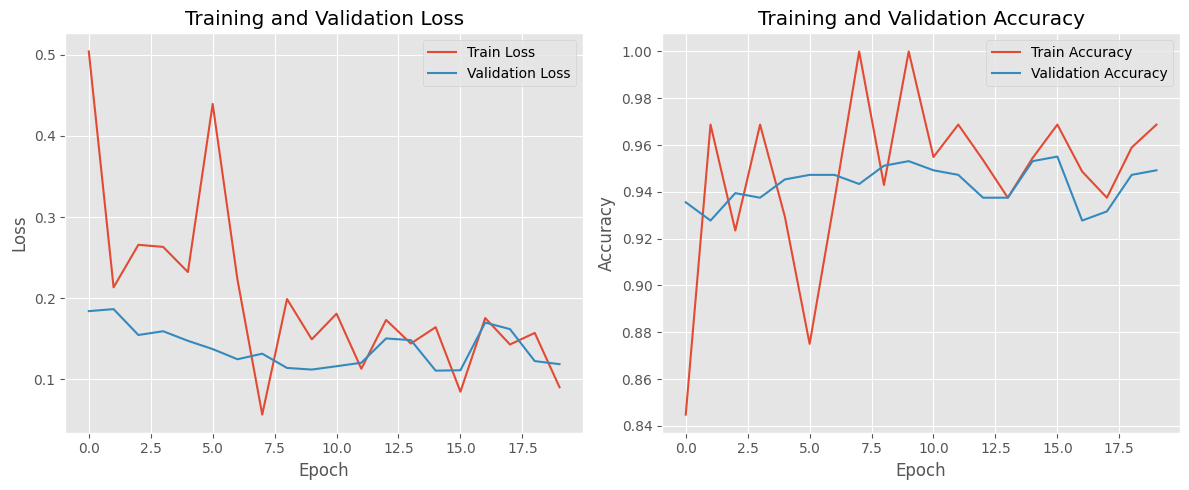

In [ ]:
# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### **Evaluation**

20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.8630 - loss: 0.2901

Test Loss: 0.1865
Test Accuracy: 0.9151
20/20 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step

Classification Report:
              precision    recall  f1-score   support

      normal     0.9415    0.8248    0.8793       234
   pneumonia     0.9021    0.9692    0.9345       390

    accuracy                         0.9151       624
   macro avg     0.9218    0.8970    0.9069       624
weighted avg     0.9169    0.9151    0.9138       624



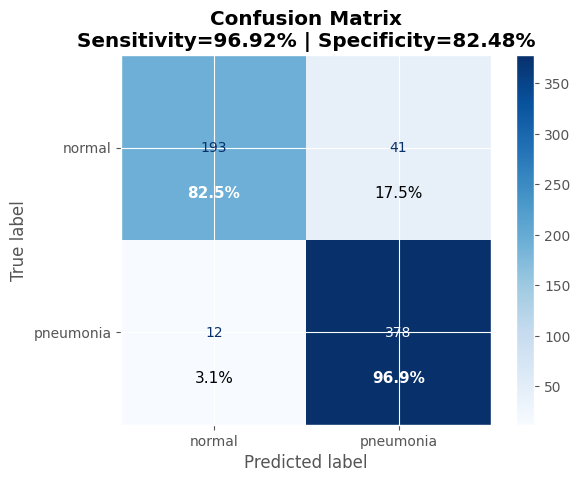

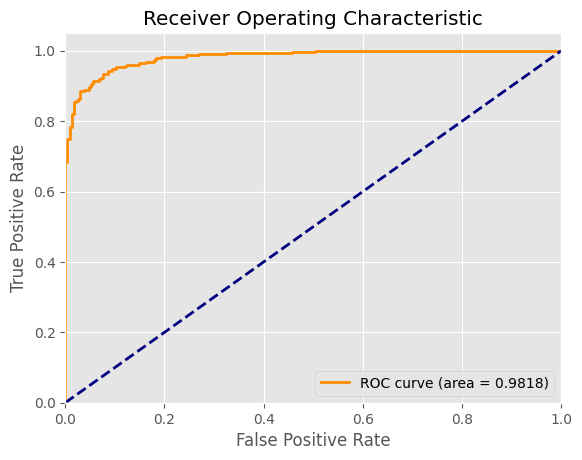


AUROC: 0.9818
Sensitivity: 0.9692
Specificity: 0.8248


In [ ]:
#  Evaluate model
model = load_model(MODEL_SAVE_PATH)

test_loss, test_acc = model.evaluate(test_generator)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

test_steps = np.ceil(test_generator.samples / BATCH_SIZE).astype(int) # Cast to int
y_pred_prob = model.predict(test_generator, steps=test_steps)
y_pred = (y_pred_prob > 0.50).astype(int).ravel()
y_true = test_generator.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4, target_names=['normal', 'pneumonia']))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['normal', 'pneumonia'])
ax = disp.plot(cmap='Blues').ax_

# Add percentages to confusion matrix
row_totals = cm.sum(axis=1)
cm_percent = (cm.astype('float') / row_totals[:, np.newaxis]) * 100

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i + 0.25, f"{cm_percent[i, j]:.1f}%",
                ha='center', va='center',
                color='white' if i == j else 'black',
                fontsize=11, weight='bold' if i == j else 'normal')

sensitivity = cm[1,1]/row_totals[1]*100
specificity = cm[0,0]/row_totals[0]*100
plt.title(f"Confusion Matrix\nSensitivity={sensitivity:.2f}% | Specificity={specificity:.2f}%", weight='bold')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print(f"\nAUROC: {roc_auc:.4f}")
print(f"Sensitivity: {sensitivity/100:.4f}")
print(f"Specificity: {specificity/100:.4f}")

#### **Model Size**

In [ ]:
#  Get the size of the best saved model
import os

MODEL_SAVE_PATH = "/content/drive/MyDrive/chest_xray/New_Models/mobileNetV2_best.h5"
model_size_bytes = os.path.getsize(MODEL_SAVE_PATH)
model_size_mb = model_size_bytes / (1024 * 1024)
print(f"Size of the best saved model: {model_size_mb:.2f} MB")

Size of the best saved model: 12.89 MB
